In [1]:
import os

curr_dir = os.path.split(os.getcwd())[1]
if curr_dir != "irl-environment-design":
    os.chdir("..")

In [2]:
import numpy as np

from src.utils.make_environment import (
    transition_matrix,
    Environment,
    insert_walls_into_T,
)

from src.utils.constants import ParamTuple

np.set_printoptions(linewidth=160, precision=2)

from src.utils.environment_design import EnvironmentDesign

from src.utils.inference.posterior import PosteriorInference

### Create Environment

In [3]:
# 0. Setup
## 0.2 Setup the environment
N, M = 7,7

# TODO describe world
agent_R = np.zeros((N, M))
agent_R[N-1, 0] = 1
agent_R[N-1, M-1] = 3



# Start by making the agent we want to learn the policy of
agent_p = 0.9
agent_gamma = 0.7
p_true=1

agent_R = agent_R.flatten()
goal_states = np.where(agent_R != 0)[0]

true_params = ParamTuple(agent_p, agent_gamma, agent_R)

wall_states = [14]

T_true = transition_matrix(N, M, p=p_true, absorbing_states=goal_states)
T_True = insert_walls_into_T(T=T_true, wall_indices=wall_states)

big_small = Environment(
    N=N,
    M=M,
    T_true=T_true,
    wall_states=wall_states,
    R_true=agent_R,
    start_state=0,
    n_walls=None,
    goal_states=goal_states
)

### Environment Design

In [4]:
env_design = EnvironmentDesign(base_environment=big_small, user_params=true_params)

In [5]:
candidate_environments_args = {}
candidate_environments_args["n_environments"] = 10
candidate_environments_args["generate_how"] = "random_walls"
candidate_environments_args["n_walls"] = 5


env_design.run_n_episodes(n_episodes=2,
                          bayesian_regret_how="value",
                          candidate_environments_args=candidate_environments_args)

big_small_observations = env_design.all_observations

Started episode 0.
Finished episode 0.
Started episode 1.


Posterior sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Evaluating candidate environments using value: 100%|██████████| 10/10 [01:11<00:00,  7.20s/it, highest_regret=0.0434]

Finished episode 1.


In [11]:
import pickle

def save_list(lst, filename):
    with open(filename, 'wb') as file:
        pickle.dump(lst, file)

def load_list(filename):
    with open(filename, 'rb') as file:
        lst = pickle.load(file)
    return lst


In [15]:
save_list(big_small_observations, filename= "tester")

In [16]:
bs = load_list("tester")

### Inference

In [18]:
pos_inference = PosteriorInference(expert_trajectories=bs,
                                    resolution = 15)

### Calculate Posterior Distribution up to and including episode 1

In [7]:
import matplotlib.pyplot as plt
import matplotlib

def plot_statistics_over_time(episode: int,
                              true_params: ParamTuple):
    
    '''
    Plot the mean and MAP over episodes.
    '''    

    #Statistics to plot.
    episodes = np.arange(episode+1)
    mean_per_episode = [pos_inference.mean(episode=i) for i in range(episode+1)]
    MAP_per_episode = [pos_inference.MAP(episode=i) for i in range(episode+1)]
    prob_true_per_episode = [pos_inference.prob_true(episode=i, true_params=true_params) for i in range(episode+1)]
    prob_true_per_episode[0] = 0

    #Extract values.
    mean_p_per_episode = [mean_per_episode[i].p for i in range(episode+1)]
    mean_gamma_per_episode = [mean_per_episode[i].gamma for i in range(episode+1)]
    MAP_p_per_episode = [MAP_per_episode[i].p for i in range(episode+1)]
    MAP_gamma_per_episode = [MAP_per_episode[i].gamma for i in range(episode+1)]


    #Plot statistics.
    # Create figure and plot the statistics.
    fix, axs = plt.subplots(1, 3, figsize=(10, 3))
    axs[0].plot(episodes, mean_p_per_episode, "x-", label="Mean $p$")
    axs[0].plot(episodes, MAP_p_per_episode, "o-", label="MAP $p$")
    axs[0].hlines(true_params.p, 0, episode, colors="r", label=f"True $p = {round(true_params.p,2)}$")
    axs[0].legend(loc="lower right")
    axs[0].set_xlabel("Episode")
    axs[0].set_ylabel("Value")
    axs[0].set_title("Statistics over Episodes")
    axs[0].set_xticks(np.arange(0, episode+1, 1.0))

    axs[1].plot(episodes, mean_gamma_per_episode, "x-", label="Mean $\gamma$")
    axs[1].plot(episodes, MAP_gamma_per_episode, "o-", label="MAP $\gamma$")
    axs[1].hlines(true_params.gamma, 0, episode, colors="r", label=f"True $\gamma = {round(true_params.gamma,2)}$")
    axs[1].legend(loc="lower right")
    axs[1].set_xlabel("Episode")
    axs[1].set_ylabel("Value")
    axs[1].set_title("Statistics over Episodes")
    axs[1].set_xticks(np.arange(0, episode+1, 1.0))

    axs[2].plot(episodes, prob_true_per_episode, "x-", label="")
    
    plt.show()

In [8]:
plot_statistics_over_time(episode=2, true_params=true_params)

AttributeError: 'PosteriorInference' object has no attribute 'posterior_distribution'

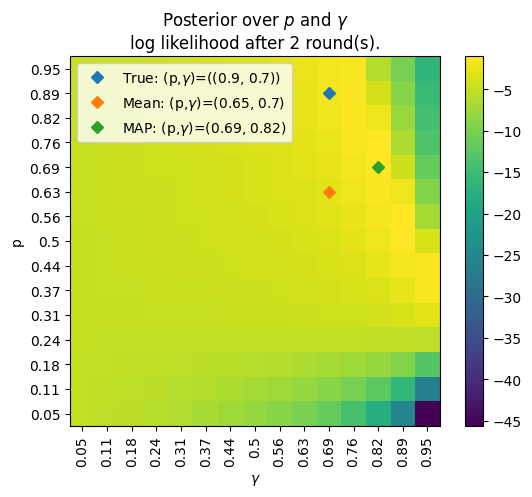

In [24]:
pos_inference.plot_posterior(episode=2,
                   param_values=true_params, show_true_prob=False)

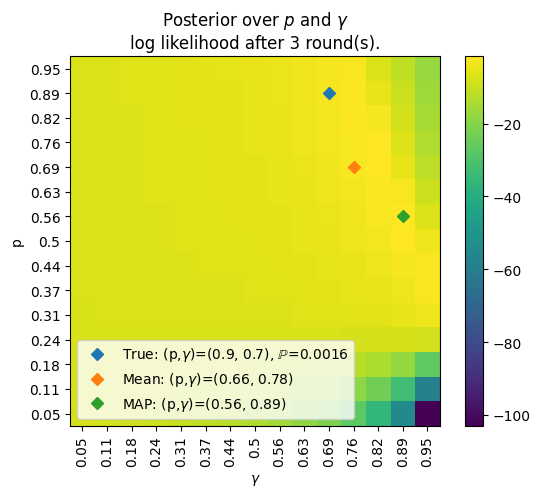

In [ ]:
pos_inference.plot(episode=3,
                   param_values=true_params)